In [1]:
import numpy as np
from scipy.optimize import minimize, Bounds

N, dt = 50, 60.0
V0, T0, V_ref, T_ref = 40.0, 20.0, 30.0, 100.0
Tb, a, beta, b = 100.0, 10.0, 7.0/3600.0, 10.0
rho_mos, cp_mos, C_rec = 1.0, 4180.0/7, 6e4/7
rho_w, h_fg, eta = 0.958, 2.257e6, 1.0#0.85
P_max, T_min, T_max = 6e3, 20.0, 102.0
w1, w2, w3, w4 = 1e0, 2e2, 1e-8, 1e-20
epsilon = 1e-6


def unpack(x):
    P = x[:N]
    T = x[N:N+N]
    V = x[N+N:]
    return P, T, V

def objective(x):
    P, T, V = unpack(x)
    deltaP = P[1:]- P[0:-1]
    return w1*np.sum((T-np.full(N, T_ref))**2) + w2*np.sum((V[-10:]-np.full(10, V_ref))**2) + w3*np.sum(deltaP) + w4*np.sum(deltaP)


def dynamics_residual(x):
    P, T, V = unpack(x)
    res = np.zeros(2*(N-1))
    for k in range(N-1):
        if T[k] < Tb:
            res[k]   = T[k+1] - T[k] - (eta*P[k]*dt) / (rho_mos*cp_mos*V[k] + C_rec)
            res[k+N-1] = V[k+1] - V[k]
        else:
            res[k]   = T[k+1] - T[k] 
            res[k+N-1] = V[k+1] - V[k] + 1e1* eta*P[k]*dt / (rho_w*h_fg)
            # res[k+N-1] = V[k+1] - V[k]*np.exp(-beta*dt * P[k]/(epsilon+P[k]))
    return res

def temperature_initial(x):
    P, T, V = unpack(x)
    return T[0] - T0

def temperature_terminal(x):
    P, T, V = unpack(x)
    return T[20] - T_ref + 1
    # return T[-1] - T_ref

def volume_initial(x):
    P, T, V = unpack(x)
    return V[0] - V0

def volume_terminal(x):
    P, T, V = unpack(x)
    return V[-1] - V_ref


cons = [
        {'type': 'eq',
        'fun': dynamics_residual},
        {'type': 'eq',
        'fun': temperature_initial},
        {'type': 'eq',
        'fun': volume_initial},
        {'type': 'eq',
        'fun': temperature_terminal},
        # {'type': 'eq',
        # 'fun': volume_terminal},
       ]


# Bounds for decisions: [P_0..P_{N-1}, T_1..T_N, V_1..V_N]
lb = np.concatenate([np.zeros(N),      T_min*np.ones(N),  0*np.ones(N)])
ub = np.concatenate([P_max*np.ones(N), T_max*np.ones(N),  (V0+5)*np.ones(N)])
bounds = Bounds(lb, ub)

# Feasible initial guess: forward simulate with constant P
# simple forward pass to build consistent T,V
P0 = np.full(N, 0.05*P_max)
P0[-1] = 0.0
Tg = np.empty(N) 
Vg = np.empty(N)
Tg[0]=T0
Vg[0]=V0
for k in range(N-1):
    if Tg[k] < Tb:
        Tg[k+1] = Tg[k] + 0.05 * (eta*P0[k]*dt) / (rho_mos*cp_mos*Vg[k] + C_rec)
        Vg[k+1] = Vg[k]
    else:
        Tg[k+1] = Tg[k] 
        # Vg[k+1] = Vg[k]*np.exp(-beta*dt* P0[k]/(epsilon+P0[k]))
        Vg[k+1] = Vg[k] - 1e1* eta*P0[k]*dt / (rho_w*h_fg)


x0 = np.concatenate([P0, Tg, Vg])



In [2]:
res = minimize(objective, x0, method='trust-constr',
               bounds=bounds, constraints=cons,
               options=dict(verbose=3, maxiter=500))

print("Status:", res.message)
P_opt, T_opt, V_opt = unpack(res.x)
print(f"V_N={V_opt[-1]:.2f} L, T_max={T_opt.max():.2f} °C, P̄={P_opt.mean():.0f} W")

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  | penalty  |barrier param|CG stop|
|-------|-------|-------|-------------|----------|----------|----------|----------|-------------|-------|
|   1   |  151  |   0   | +5.1460e+05 | 1.00e+00 | 8.47e+00 | 7.84e+01 | 1.00e+00 |  1.00e-01   |   0   |
|   2   |  302  |   1   | +5.1458e+05 | 7.00e+00 | 8.46e+00 | 7.84e+01 | 1.00e+00 |  1.00e-01   |   2   |


c:\Python312\Lib\site-packages\scipy\optimize\_differentiable_functions.py:551: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


|   3   |  453  |   3   | +5.1424e+05 | 3.92e+01 | 8.46e+00 | 7.84e+01 | 1.74e+02 |  1.00e-01   |   4   |
|   4   |  604  |   5   | +5.1224e+05 | 2.20e+02 | 8.42e+00 | 7.81e+01 | 3.64e+06 |  1.00e-01   |   4   |
|   5   |  755  |   7   | +5.0118e+05 | 1.23e+03 | 8.23e+00 | 7.64e+01 | 6.22e+07 |  1.00e-01   |   4   |
|   6   |  906  |   9   | +4.4361e+05 | 6.88e+03 | 7.12e+00 | 6.71e+01 | 5.18e+08 |  1.00e-01   |   4   |
|   7   | 1057  |  11   | +3.1071e+05 | 2.17e+04 | 3.64e+00 | 3.75e+01 | 1.78e+09 |  1.00e-01   |   4   |
|   8   | 1208  |  13   | +2.7184e+05 | 2.17e+04 | 2.12e+00 | 2.26e+01 | 1.78e+09 |  1.00e-01   |   4   |
|   9   | 1359  |  15   | +2.5937e+05 | 2.17e+04 | 2.02e+00 | 1.51e+01 | 1.78e+09 |  1.00e-01   |   4   |
|  10   | 1510  |  17   | +2.5489e+05 | 2.17e+04 | 2.22e+00 | 1.14e+01 | 1.78e+09 |  1.00e-01   |   4   |
|  11   | 1661  |  19   | +2.5281e+05 | 2.17e+04 | 7.77e+00 | 9.39e+00 | 1.78e+09 |  1.00e-01   |   4   |
|  12   | 1812  |  21   | +2.5060e+05 | 2.17e+

c:\Python312\Lib\site-packages\scipy\optimize\_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


|  97   | 18573 | 1217  | +2.2197e+04 | 3.30e+01 | 8.68e-01 | 5.62e-13 | 1.78e+09 |  1.00e-01   |   2   |
|  98   | 18875 | 1249  | +2.2188e+04 | 2.31e+02 | 8.67e-01 | 2.58e-12 | 1.78e+09 |  1.00e-01   |   2   |
|  99   | 19177 | 1293  | +2.2188e+04 | 2.31e+01 | 8.67e-01 | 2.58e-12 | 1.78e+09 |  1.00e-01   |   2   |
|  100  | 19479 | 1337  | +2.2181e+04 | 1.62e+02 | 8.66e-01 | 9.61e-12 | 1.78e+09 |  1.00e-01   |   2   |
|  101  | 19630 | 1375  | +2.2181e+04 | 1.62e+01 | 8.66e-01 | 9.61e-12 | 1.78e+09 |  1.00e-01   |   2   |
|  102  | 19932 | 1407  | +2.2177e+04 | 8.26e+01 | 8.66e-01 | 4.86e-13 | 1.78e+09 |  1.00e-01   |   2   |
|  103  | 20083 | 1442  | +2.2177e+04 | 8.26e+00 | 8.66e-01 | 4.86e-13 | 1.78e+09 |  1.00e-01   |   2   |
|  104  | 20385 | 1474  | +2.2174e+04 | 5.78e+01 | 8.66e-01 | 4.80e-14 | 1.78e+09 |  1.00e-01   |   2   |
|  105  | 20536 | 1503  | +2.2174e+04 | 5.78e+00 | 8.66e-01 | 4.80e-14 | 1.78e+09 |  1.00e-01   |   2   |
|  106  | 20838 | 1531  | +2.2173e+04 | 4.05e+

In [3]:
# %matplotlib inline
# Caso queira ver as três séries:
import matplotlib.pyplot as plt
t = np.arange(N)*dt/60.0   # minutos

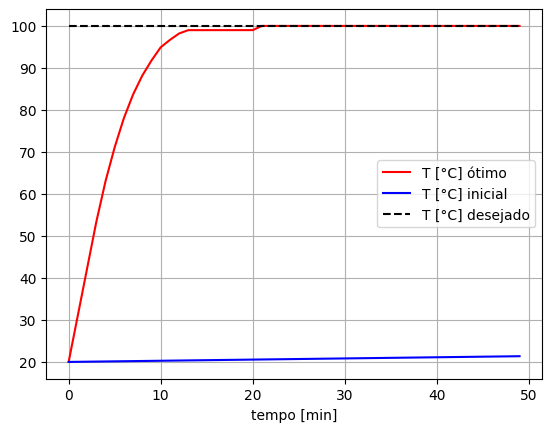

In [4]:
# %matplotlib inline
plt.plot(t, T_opt, color='red', label='T [°C] ótimo')
plt.plot(t, Tg, color='blue',label='T [°C] inicial')
plt.plot(t, np.full(T_opt.shape, T_ref), '--',color='black', label='T [°C] desejado')
plt.legend(); plt.xlabel('tempo [min]'); plt.grid(True); plt.show()

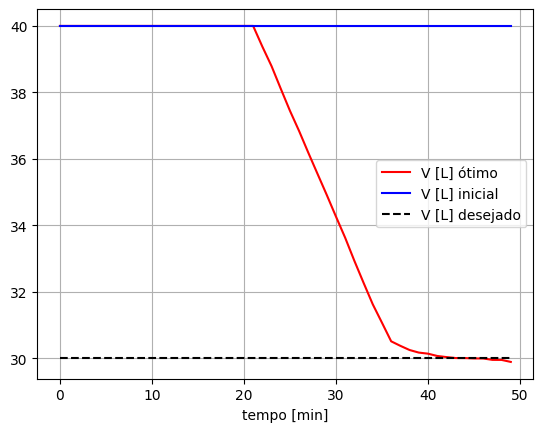

In [5]:
plt.plot(t, V_opt, color='red', label='V [L] ótimo')
plt.plot(t, Vg, color='blue', label='V [L] inicial')
plt.plot(t, np.full(V_opt.shape, V_ref), '--',color='black', label='V [L] desejado')
plt.legend(); plt.xlabel('tempo [min]'); plt.grid(True); plt.show()

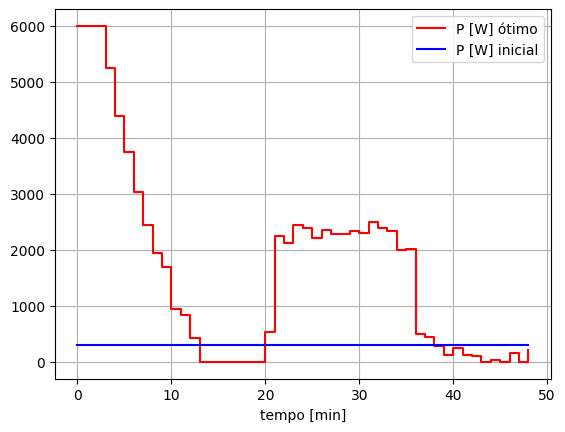

In [6]:
plt.step(t[:-1], P_opt[:-1], where='post', color = 'red', label='P [W] ótimo')
plt.step(t[:-1], P0[:-1], where='post', color = 'blue', label='P [W] inicial')
plt.legend(); plt.xlabel('tempo [min]'); plt.grid(True); plt.show()


# Simulations

In [7]:
# Feasible initial guess: forward simulate with constant P
# simple forward pass to build consistent T,V

Tsim = np.empty(N) 
Vsim = np.empty(N)
Tsim[0]=T0
Vsim[0]=V0
for k in range(N-1):
    if Tsim[k] < Tb:
        Tsim[k+1] = Tsim[k] + (eta*P_opt[k]*dt) / (rho_mos*cp_mos*Vsim[k] + C_rec)
        Vsim[k+1] = Vsim[k]
    else:
        Tsim[k+1] = Tsim[k] 
        Vsim[k+1] = Vsim[k]*np.exp(-beta*dt* P_opt[k]/(epsilon+P_opt[k]))
        Vsim[k+1] = Vsim[k] - 1e1* eta*P_opt[k]*dt / (rho_w*h_fg)


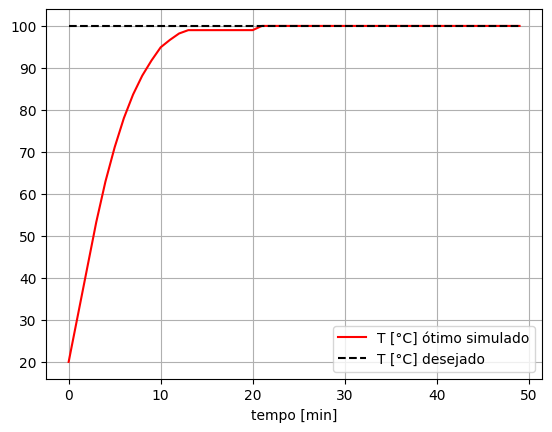

In [8]:
# %matplotlib inline
plt.plot(t, Tsim, color='red', label='T [°C] ótimo simulado')
plt.plot(t, np.full(T_opt.shape, T_ref), '--',color='black', label='T [°C] desejado')
plt.legend(); plt.xlabel('tempo [min]'); plt.grid(True); plt.show()

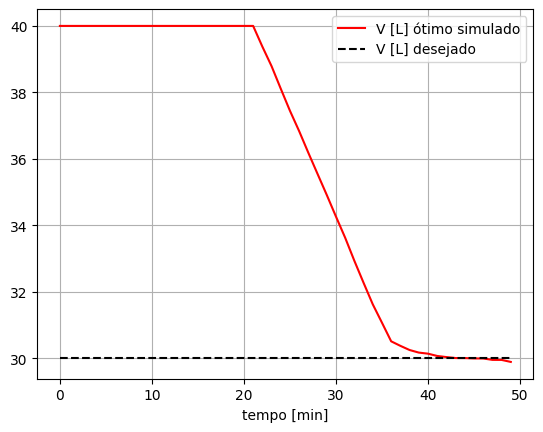

In [9]:
plt.plot(t, Vsim, color='red', label='V [L] ótimo simulado')
plt.plot(t, np.full(V_opt.shape, V_ref), '--',color='black', label='V [L] desejado')
plt.legend(); plt.xlabel('tempo [min]'); plt.grid(True); plt.show()